In [ ]:
# import part
import zipfile
import os
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import normaltest, shapiro
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, RFE, mutual_info_classif, RFECV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline




In [5]:
with zipfile.ZipFile('tm10007_ml/ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('tm10007_ml/ecg')

data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

labels = data.iloc[:,-1]
x = data.iloc[:,:-1]

X_train, X_test, y_train, y_test = train_test_split(x, labels, test_size=0.25, stratify=labels, random_state=42)


          0_0       0_1       0_2       0_3       0_4       0_5       0_6  \
0_0  1.000000  0.439681  0.429406  0.366741  0.299724  0.183853  0.183019   
0_1  0.439681  1.000000  0.847322  0.657326  0.495580  0.387480  0.310722   
0_2  0.429406  0.847322  1.000000  0.834260  0.666997  0.478997  0.458244   
0_3  0.366741  0.657326  0.834260  1.000000  0.841910  0.571158  0.617057   
0_4  0.299724  0.495580  0.666997  0.841910  1.000000  0.538358  0.653084   
0_5  0.183853  0.387480  0.478997  0.571158  0.538358  1.000000  0.341973   
0_6  0.183019  0.310722  0.458244  0.617057  0.653084  0.341973  1.000000   
0_7  0.136971  0.245667  0.392874  0.564919  0.595546  0.220834  0.545089   
0_8  0.170718  0.345170  0.464278  0.575268  0.610618  0.275434  0.451378   
0_9  0.183579  0.326894  0.467887  0.655506  0.750329  0.461928  0.524803   

          0_7       0_8       0_9  
0_0  0.136971  0.170718  0.183579  
0_1  0.245667  0.345170  0.326894  
0_2  0.392874  0.464278  0.467887  
0_3  0.5

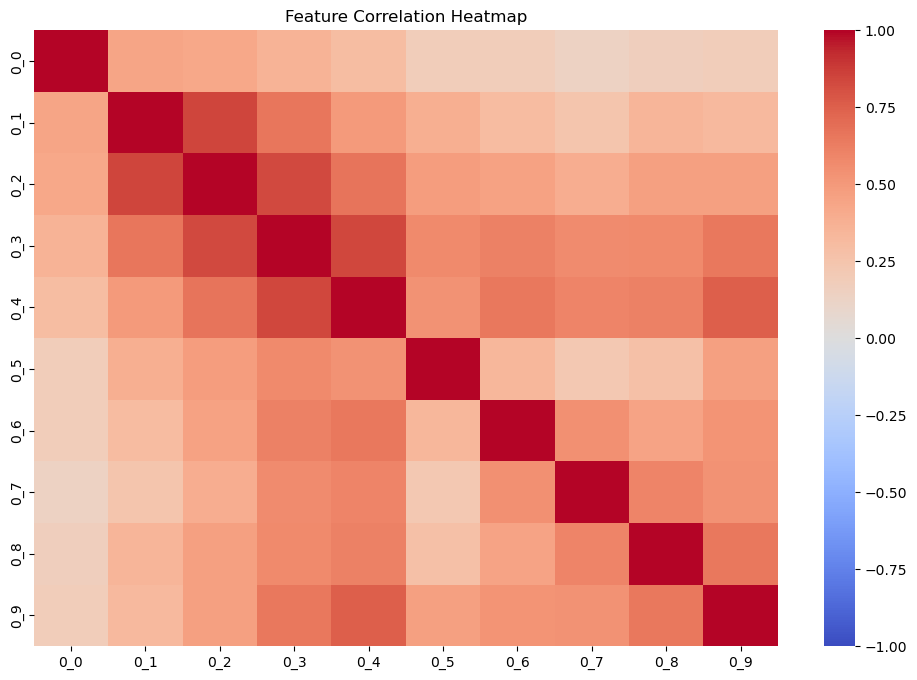

In [ ]:
# Compute correlation matrix
correlation_matrix = X_train.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix.iloc[:10, :10], cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()


In [ ]:

# Train Random Forest on the training set
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Get feature importance
feature_importance = pd.Series(rf.feature_importances_, index=X_train.columns)
top_features = feature_importance.nlargest(300).index  # Select top 300 features

# Apply log transformation to selected features (avoiding negative values)
data_transformed = np.log1p(X_train[top_features])  # Use X_train, not entire dataset!

# Check normality
normal_features = []
non_normal_features = []

for feature in top_features:  
    # Use Shapiro-Wilk test for small samples, else normaltest for large datasets
    if len(X_train) <= 5000:
        stat, p = shapiro(data_transformed[feature])
    else:
        stat, p = normaltest(data_transformed[feature])  # More reliable for large datasets

    if p > 0.05:
        normal_features.append(feature)
    else:
        non_normal_features.append(feature)

print(f"Normal Features: {len(normal_features)}")
print(f"Non-Normal Features: {len(non_normal_features)}")

Normal Features: 40
Non-Normal Features: 260


In [17]:
# Select top 300 features with the highest F-statistic
selector = SelectKBest(score_func=mutual_info_classif, k=300)
X_train_selected = selector.fit_transform(X_train, y_train)

# Use LDA as the estimator (since it's similar to QDA but more stable for feature selection)
lda = LinearDiscriminantAnalysis()  # LDA as a baseline for QDA

# Cross-validation
cv = StratifiedKFold(n_splits=5)

rfecv = RFECV(estimator=lda, step=1, cv=cv, scoring='accuracy', n_jobs=-1)
X_train_final = rfecv.fit_transform(X_train_selected, y_train)
X_train_final = np.log1p(X_train_final)

# Check normality
normal_features = []
non_normal_features = []

for feature in range(X_train_final.shape[1]):
    stat, p = shapiro(X_train_final[:, feature])
    if p > 0.05:
        normal_features.append(feature)
    else:
        non_normal_features.append(feature)

print(f"Normal Features: {len(normal_features)}")
print(f"Non-Normal Features: {len(non_normal_features)}")


Normal Features: 0
Non-Normal Features: 1


In [19]:
# Select top 300 features with the highest F-statistic
selector = SelectKBest(score_func=mutual_info_classif, k=300)
X_train_selected = selector.fit_transform(X_train, y_train)

# Use LDA as the estimator (since it's similar to QDA but more stable for feature selection)
lda = LinearDiscriminantAnalysis()  # LDA as a baseline for QDA

rfe = RFE(estimator=lda, n_features_to_select=100)
X_train_final = rfe.fit_transform(X_train_selected, y_train)
X_train_final = np.log1p(X_train_final)

# Check normality
normal_features = []
non_normal_features = []

for feature in range(X_train_final.shape[1]):
    stat, p = shapiro(X_train_final[:, feature])
    if p > 0.05:
        normal_features.append(feature)
    else:
        non_normal_features.append(feature)

print(f"Normal Features: {len(normal_features)}")
print(f"Non-Normal Features: {len(non_normal_features)}")

Normal Features: 0
Non-Normal Features: 100
